## Running Measures: Robustness and Faithfulness

This notebook shows the functionality of the different tests.

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip install captum
!pip install opencv-python
!pip install torch==1.9.0+cu102 torchvision==0.9.1

import torch
import torchvision
from torchvision import transforms
import numpy as np
import h5py
from tqdm import tqdm
from captum.attr import Saliency, IntegratedGradients
from pathlib import Path
import warnings

# Retrieve source code.
from drive.MyDrive.Projects.xai_quantification_toolbox import * #import xaiquantificationtoolbox

# Notebook settings.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2

#import gc
#gc.collect()
#torch.cuda.empty_cache()

     |████████████████████████████████| 4.4MB 7.5MB/s 
     |████████████████████████████████| 17.4MB 286kB/s 
ERROR: torchvision 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.9.0+cu102 which is incompatible.
  Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102


### Load model, data and attributions.

In [ ]:
# Load pre-trained ResNet18 model.
model = torchvision.models.resnet18(pretrained=True)
model.eval()

# Load test data and loaders.
test_set = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/imagenet_images',
                                            transform=transforms.Compose([transforms.Resize(256),
                                                                          transforms.CenterCrop((224, 224)),
                                                                          transforms.ToTensor(),
                                                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
test_loader = torch.utils.data.DataLoader(test_set, shuffle=True, batch_size=24)


# Evaluate model performance.
#predictions, labels = evaluate_model(model.to(device), data=test_loader, device=device)
#print(f"\nModel test accuracy: {(100 * score_model(predictions, labels)):.2f}%")

# Load data, targets and attributions.
x_batch, y_batch = iter(test_loader).next()
a_batch = explain(model.to(device), x_batch.to(device), y_batch.to(device), explanation_func="Saliency")

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


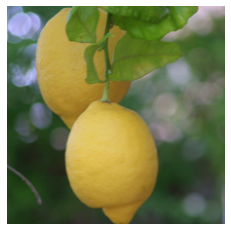

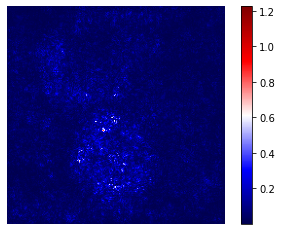

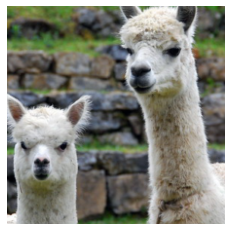

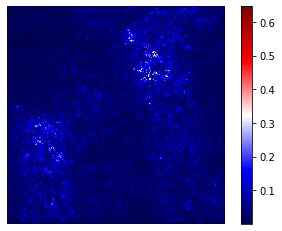

In [ ]:
# Plot some explanations!
import matplotlib.pyplot as plt

for i in range(10, 12): #[4140, 2091, 78, 1195]: 
    plt.imshow(denormalize_image(x_batch.cpu().data[i]).transpose(0, 1).transpose(1, 2))
    plt.axis("off")
    plt.show()
    plt.imshow(a_batch.cpu().data[i], cmap="seismic")
    plt.colorbar()
    plt.axis("off")
    plt.show()

### Robustness tests

In [ ]:
# One-liner to measure robustness of provided attributions.
scores = RobustnessTest(**{
    "similarity_func": lipschitz_constant,
    "perturb_func": gaussian_noise,
})(model=model, 
   x_batch=x_batch.cpu().numpy(), 
   y_batch=y_batch.cpu().numpy(), 
   a_batch=a_batch.cpu().numpy(), 
   **{"explanation_func": "Saliency", "device": device})

scores

[96.48842162560496,
 178.4140665193743,
 78.69479740242612,
 145.74971805550942,
 74.26186926887445,
 320.2143662328544,
 157.5281525392813,
 68.22164651646081,
 76.50171237791368,
 159.00233119270774,
 307.27169366282004,
 121.83412829613306,
 110.59442569202737,
 148.3999948718393,
 199.127668664823,
 153.49932602495306,
 92.97986488827927,
 201.2483844421969,
 177.0458527035045,
 185.30069287930053,
 190.72830725150854,
 247.15747172070726,
 60.42394392378093,
 155.77217434272703]

In [ ]:
# One-liner to measure robustness of provided attributions.
rt = RobustnessTest(**{
    "similarity_func": lipschitz_constant,
    "perturb_func": gaussian_noise,
})
rt(model=model, 
   x_batch=x_batch.cpu().numpy(), 
   y_batch=y_batch.cpu().numpy(), 
   a_batch=a_batch.cpu().numpy(), 
   **{"explanation_func": "Saliency", "device": device})

rt.README


        • What the output mean

        • What a high versus low value indicates

        • Assumptions (to be concerned about)

        • Further reading

        Parameters
        ----------
        model
        x_batch
        y_batch
        a_batch
        kwargs

        Returns
        -------

        


In [ ]:
# One-liner to measure continuity of provided attributions.
scores = ContinuityTest(**{
    "similarity_func": correlation_spearman,
    "perturb_func": translation_x_direction,
    "nr_patches": 4,
    "nr_steps": 10,
})(model=model, 
   x_batch=x_batch.cpu().numpy(),
   y_batch=y_batch.cpu().numpy(),
   a_batch=a_batch.cpu().numpy(),
   **{"explanation_func": "Saliency", "device": device})

scores

Continuity test correlation coefficient: 0.5905


{0: {0: [502.4458923339844,
   450.24249267578125,
   381.42626953125,
   270.82073974609375,
   189.09884643554688,
   144.51492309570312,
   91.86256408691406,
   106.53133392333984,
   84.90377044677734,
   81.59573364257812],
  1: [371.50115966796875,
   516.2485961914062,
   491.99267578125,
   554.076416015625,
   638.1890258789062,
   641.49267578125,
   590.3630981445312,
   431.429443359375,
   337.8974304199219,
   189.65554809570312],
  2: [319.5810546875,
   229.03060913085938,
   174.51373291015625,
   174.48736572265625,
   141.51571655273438,
   104.41879272460938,
   79.0236587524414,
   71.71922302246094,
   86.76939392089844,
   76.32160949707031],
  3: [345.71978759765625,
   391.7928466796875,
   358.37017822265625,
   477.3447570800781,
   411.385986328125,
   324.42572021484375,
   287.19305419921875,
   211.9081268310547,
   212.47198486328125,
   217.6006622314453],
  4: [15.511678695678711,
   14.505461692810059,
   12.942370414733887,
   11.476811408996582,
  

In [ ]:
# One-liner to measure input independence of provided attributions.
scores = InputIndependenceRate(**{
    "similarity_func": abs_difference,
    "perturb_func": optimization_scheme, # TODO.
    "perturb_std": 0.01,
    "threshold": 0.01, # 0.1
})(model=model, 
   x_batch=x_batch.cpu().numpy(), 
   y_batch=y_batch.cpu().numpy(), 
   a_batch=a_batch.cpu().numpy(), 
   **{"explanation_func": "Saliency", "device": device})

scores

0.3157894736842105

In [ ]:
# One-liner to measure local lipschitz constant of provided attributions.
scores = LocalLipschitzEstimate(**{
    "similarity_func": lipschitz_constant,
    "perturb_func": gaussian_noise,
    "distance_numerator": distance_euclidean,
    "distance_denominator": distance_euclidean,
    "perturb_std": 0.1,
    "nr_steps": 10, #200
})(model=model, 
   x_batch=x_batch.cpu().numpy(), 
   y_batch=y_batch.cpu().numpy(), 
   a_batch=a_batch.cpu().numpy(), 
   **{"explanation_func": "Saliency", "device": device})

scores

[23.542169433589983,
 32.66392368870335,
 14.600109844271783,
 29.407388345065588,
 14.230329142795767,
 42.239966265607876,
 33.228287712733625,
 17.815684040380365,
 18.917015094131976,
 39.165338344825045,
 48.54390296779312,
 30.51588309043833,
 19.235550780555872,
 25.51579619844262,
 35.08227420702533,
 27.54608094173356,
 22.392798943526593,
 48.25669804735126,
 41.66674330931109,
 38.04729622036718,
 35.03732475058819,
 39.45317731568805,
 15.525775661226879,
 33.87436994393717]

In [ ]:
# One-liner to measure sensitivity max of provided attributions.
scores = SensitivityMax(**{
    "similarity_func": difference,
    "perturb_func": uniform_sampling,
    "norm_numerator": fro_norm,
    "norm_denominator": fro_norm,
    "perturb_radius": 0.2,
    "nr_steps": 10,
})(model=model, 
   x_batch=x_batch.cpu().numpy(), 
   y_batch=y_batch.cpu().numpy(), 
   a_batch=a_batch.cpu().numpy(), 
   **{"explanation_func": "Saliency", "device": device})
scores

[0.017014492,
 0.016118279,
 0.0060418583,
 0.016958734,
 0.007384982,
 0.016230874,
 0.022452543,
 0.018884141,
 0.009942983,
 0.03232568,
 0.036992952,
 0.02148441,
 0.012842706,
 0.018439323,
 0.0215814,
 0.015977573,
 0.011610743,
 0.043504383,
 0.040106196,
 0.018698081,
 0.017724494,
 0.015953045,
 0.012121835,
 0.021970132]

### Faithfulness tests

In [ ]:
    # One-liner to for faithfulness base class of provided attributions.
scores = FaithfulnessTest(**{
    "perturb_func": baseline_replacement_by_indices,
    "similarity_func": correlation_spearman,
    "perturb_baseline": 0.0,  
    "pixels_in_step": 128,
})(model=model, 
   x_batch=x_batch.cpu().numpy(), 
   y_batch=y_batch.cpu().numpy(), 
   a_batch=a_batch.cpu().numpy(), 
   **{"explanation_func": "Saliency", "device": device})

scores

[-0.3367603928395122,
 -0.4216837083323206,
 0.16064611177923457,
 0.3387802515629551,
 0.3741468044237277,
 0.035699244848951865,
 -0.1861110856556363,
 -0.18784646284667203,
 0.1556572180813912,
 0.06473030632764223,
 -0.11389281899284771,
 0.30355195513319827,
 -0.5480763828930179,
 -0.21819693692279432,
 0.7063015050029304,
 -0.08297278420163284,
 -0.5534030406055551,
 0.08608753823467655,
 0.3855523623322545,
 -0.5913428763473527,
 0.6060879047935137,
 0.354856446395352,
 0.4598701744222415,
 0.20375392108386664]

In [ ]:
# One-liner to measure faithfulness estimate of provided attributions.
scores = FaithfulnessEstimate(**{
    "perturb_func": baseline_replacement_by_indices,
    "similarity_func": correlation_pearson,
    "perturb_baseline": 0.0,  
    "pixels_in_step": 224,
})(model=model,
   x_batch=x_batch.cpu().numpy(),
   y_batch=y_batch.cpu().numpy(), 
   a_batch=a_batch.cpu().numpy(), 
   **{"explanation_func": "Saliency", "device": device})

scores

[-0.2885833221619646,
 -0.2827289492222568,
 0.23901680058721478,
 0.6358810036503635,
 0.4947128478716839,
 0.13746414140138435,
 -0.31454372690126625,
 -0.30492581119419865,
 0.5044869639231885,
 0.28951961998522047,
 0.26888317984439636,
 -0.07409259425563297,
 -0.3665958157305951,
 -0.3188932166240083,
 0.9075164978812578,
 0.06003540488612867,
 -0.5747756387969682,
 -0.06639368600167363,
 0.29301996076065806,
 -0.41782871756560813,
 0.6526630435895798,
 0.31298302505105047,
 0.5821946775439272,
 0.22946737762100664]

In [ ]:
# One-liner to measure infidelity of provided attributions.
scores = Infidelity(**{
    "perturb_func": baseline_replacement_by_patch,
    "similarity_func": mse,
    "perturb_baseline": "black",  
    "perturb_patch_sizes": [14, 28] #list(np.arange(10,30)),
})(model=model, 
  x_batch=x_batch.cpu().numpy(), 
  y_batch=y_batch.cpu().numpy(), 
  a_batch=a_batch.cpu().numpy(), 
  **{"explanation_func": "Saliency", "device": device})

scores

[945.1060944302174,
 129.0074304231844,
 158.50728391941428,
 248.7489244722548,
 362.8554847871597,
 352.55106620939546,
 310.13847754052307,
 436.3085305744265,
 275.62867327028357,
 430.94952200939144,
 290.4946726985401,
 295.86469767342965,
 543.7330770043217,
 251.66921479794703,
 1470.3837425313875,
 498.34867451317484,
 373.25608991105275,
 877.8818590965907,
 407.70405549669573,
 270.08723199992517,
 496.63844630891765,
 1067.637411111958,
 432.1768901344979,
 646.6629444578489]

In [ ]:
# One-liner to measure montonicity metric of provided attributions.
scores = MonotonicityMetric(**{
    "perturb_func": baseline_replacement_by_indices,
    "similarity_func": correlation_spearman,
    "perturb_baseline": 0.0,
    "pixels_in_step": 28,
})(model=model, 
   x_batch=x_batch.cpu().numpy(),
   y_batch=y_batch.cpu().numpy(), 
   a_batch=a_batch.cpu().numpy(),
   **{"explanation_func": "Saliency", "device": device})

scores

[0.2880674781123212,
 0.475239162929746,
 -0.22035660901131757,
 -0.3604778882334872,
 -0.45834828101644254,
 -0.04292120435618194,
 0.3447224001708308,
 0.23032457826179803,
 -0.2312353192398036,
 -0.14445974802477046,
 0.21500854153320523,
 -0.09727845398248987,
 0.6145697202647876,
 0.24605487935084353,
 -0.8191287636130686,
 -0.015968396327140724,
 0.6752884569956618,
 -0.020447362801622897,
 -0.5001644245142004,
 0.6946444586803332,
 -0.6515673713431562,
 -0.4701078368567158,
 -0.4217947896647449,
 -0.3378101644245143]

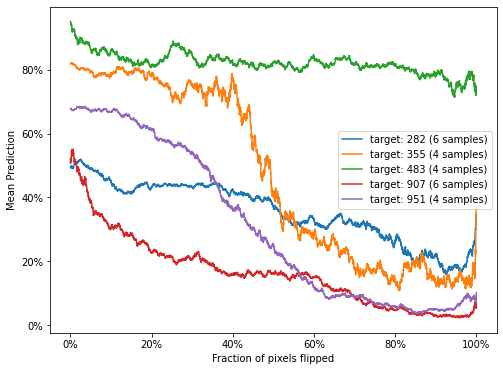

In [ ]:
# One-liner to conduct pixel-flipping experiment of provided attributions.
scores = PixelFlipping(**{,
    "perturb_func": baseline_replacement_by_indices,
    "perturb_baseline": "black"
    "pixels_in_step": 8, # 1
})(model=model,
   x_batch=x_batch.cpu().numpy(),
   y_batch=y_batch.cpu().numpy(),
   a_batch=a_batch.cpu().numpy(),
   **{"explanation_func": "Saliency", "device": device})

# Plot example!
plot_pixel_flipping_experiment(y_batch, scores)

AOPC (MoRF): 0.0095
AOPC (MoRF): 0.0094


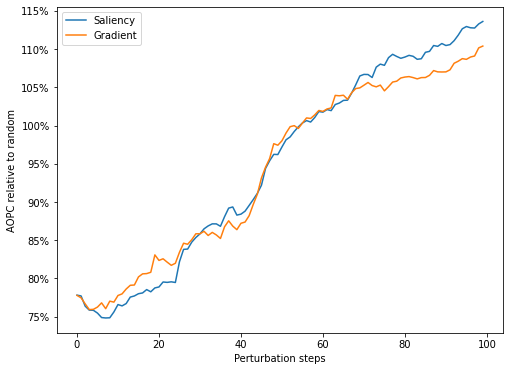

In [ ]:
# One-liner to measure faithfulness estimate of provided attributions.
scores = {method: RegionPerturbation(**{
    "perturb_func": baseline_replacement_by_patch,
    "perturb_baseline": "uniform",  
    "patch_size": 8,
    "regions_evaluation": 100,
    "random_order": False
})(model=model, 
   x_batch=x_batch.cpu().numpy(),
   y_batch=y_batch.cpu().numpy(), 
   a_batch=a_batch.cpu().numpy(), 
   **{"explanation_func": method, "device": device}) for method in ["Saliency", "Gradient"]}

# Plot example!
plot_region_perturbation_experiment(scores)

AUC: 7422.1977


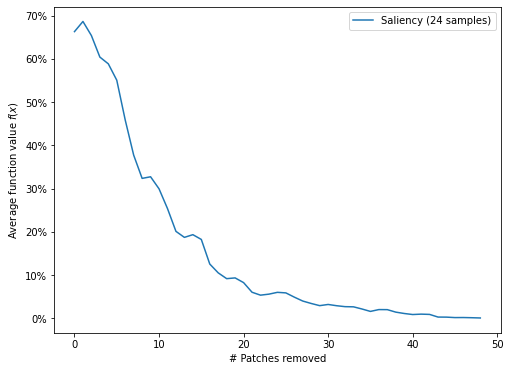

In [ ]:
# One-liner to measure faithfulness estimate of provided attributions.
scores = Selectivity(**{
    "perturb_func": baseline_replacement_by_patch,
    "perturb_baseline": "black",  
    "patch_size": 32
})(model=model, 
   x_batch=x_batch.cpu().numpy(),
   y_batch=y_batch.cpu().numpy(), 
   a_batch=a_batch.cpu().numpy(), 
   **{"explanation_func": "Saliency", "device": device})

# Plot example!
plot_selectivity_experiment({"Saliency": scores})

In [ ]:
# One-liner to measure faithfulness estimate of provided attributions.
scores = SensitivityN(**{
    "perturb_func": baseline_replacement_by_patch,
    "similarity_func": correlation_pearson,
    "n_max_percentage": 0.8,
    "perturb_baseline": "black",  
    "patch_size": 32
})(model=model, 
   x_batch=x_batch.cpu().numpy(),
   y_batch=y_batch.cpu().numpy(), 
   a_batch=a_batch.cpu().numpy(), 
   **{"explanation_func": "Saliency", "device": device})

# Plot example!
plot_selectivity_experiment(scores)

In [ ]:
class IterativeRemovalOfFeatures(Measure):
    """
    Implementation of Iterative Removal of Features by Rieger at el., 2020.

    Description.

    References:
        1) 


    Todo. Improve visualisation.

    """

    def __init__(self, *args, **kwargs):
        self.args = args
        self.kwargs = kwargs
        self.perturb_func = self.kwargs.get("perturb_func", baseline_replacement_by_indices)
        self.perturb_baseline = self.kwargs.get("perturb_baseline", 0.0)

        self.img_size = self.kwargs.get("img_size", 224)
        self.nr_channels = self.kwargs.get("nr_channels", 3)

        self.pixels_in_step = self.kwargs.get("pixels_in_step", 1)
        assert (
                       self.img_size * self.img_size) % self.pixels_in_step == 0, "Set 'pixels_in_step' so that the modulo remainder returns 0 given the image size."
        self.max_steps_per_input = self.kwargs.get("max_steps_per_input", None)

        if self.max_steps_per_input is not None:
            assert (
                           self.img_size * self.img_size) % self.max_steps_per_input == 0, "Set 'max_steps_per_input' so that the modulo remainder returns 0 given the image size."
            self.pixels_in_step = (self.img_size * self.img_size) / self.max_steps_per_input

        super(Measure, self).__init__()

    def __call__(
            self,
            model,
            x_batch: np.array,
            y_batch: Union[np.array, int],
            a_batch: Union[np.array, None],
            **kwargs
    ):
        assert (
                "explanation_func" in kwargs
        ), "To run RobustnessTest specify 'explanation_func' (str) e.g., 'Gradient'."
        assert (
                np.shape(x_batch)[0] == np.shape(a_batch)[0]
        ), "Inputs and attributions should include the same number of samples."

        if a_batch is None:
            explain(
                model.to(kwargs.get("device", None)),
                x_batch,
                y_batch,
                explanation_func=kwargs.get("explanation_func", "Gradient"),
                device=kwargs.get("device", None),
            )

        results = []

        for ix, (x, y, a) in enumerate(zip(x_batch, y_batch, a_batch)):

            # Get indices of sorted attributions (descending).
            a = abs(a.flatten())
            a_indices = np.argsort(a)

            preds = []

            for i_ix, a_ix in enumerate(a_indices[::self.pixels_in_step]):
                # Perturb input by indices of attributions.
                a_ix = a_indices[(self.pixels_in_step * i_ix):(self.pixels_in_step * (i_ix + 1))]
                x_perturbed = self.perturb_func(img=x.flatten(),
                                                **{"index": a_ix, "perturb_baseline": self.perturb_baseline})
                # Predict on perturbed input x.
                with torch.no_grad():
                    y_pred_i = float(torch.nn.Softmax()(model(torch.Tensor(x_perturbed)
                                           .reshape(1, self.nr_channels, self.img_size, self.img_size)
                                           .to(kwargs.get("device", None))))[:, y])
                preds.append(float(y_pred_i))

            results.append(preds)

        return results

Option 1. Evaluate the robustness of attributions in one line of code.

Option 2. Evaluate the robustness of provided attributions while enjoying more functionality of Quantifier and Plotting.

In [ ]:
# Provide notebooks for the different use cases: compare models, XAI methods, different measures
# ...

In [ ]:
# Specify the tests.
tests = [RobustnessTest(**{
    "similarity_function": similarity_fn,
    "perturbation_function": gaussian_blur,
}) for similarity_fn in [lipschitz_constant, distance_euclidean, cosine]]

# Load attributions of another explanation method.
a_batch_intgrad = IntegratedGradients(model).attribute(inputs=x_batch, targets=y_batch)

# Init the quantifier object.
quantifier = Quantifier(measures=tests, io_object=h5py.File("PATH_TO_H5PY_FILE"), checkpoints=..)

# Score the tests.
results = [quantifier.score(model=model, x_batch=x_batch, y_batch=y_batch, a_batch=a_batch)
           for a_batch in [a_batch_saliency, a_batch_intgrad]]

# Plot Saliency vs Integrated Gradients.
Plotting(results, show=False, path_to_save="PATH_TO_SAVE_FIGURE")